In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm.auto import tqdm
import torch
from torch import nn
import gin
import pickle
import io
from sparse_causal_model_learner_rl.trainable.gumbel_switch import WithInputSwitch, sample_from_logits_simple
gin.enter_interactive_mode()

In [3]:
ckpt = '/home/sergei/ckpt_no_recover_logitsreset'

In [104]:
class LinearModel(nn.Module):
    def __init__(self, input_shape):
        super(LinearModel, self).__init__()
        self.layer = nn.Linear(in_features=10, out_features=1, bias=True)
    def forward(self, x):
        return self.layer(x)

In [105]:
import ray
ray.init(address='10.90.38.7:6379', ignore_reinit_error=True)

2021-01-29 12:08:13,389	INFO worker.py:651 -- Connecting to existing Ray cluster at address: 10.90.38.7:6379
2021-01-29 12:08:13,391	ERROR worker.py:660 -- Calling ray.init() again after it has already been called.


In [106]:
# https://github.com/pytorch/pytorch/issues/16797
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)

In [107]:
with open(ckpt, 'rb') as f:
    learner = pickle.load(f)#CPU_Unpickler(f).load()#pickle.load(f)

2021-01-29 12:08:16,688	WARNING session.py:20 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Selecting name 49868b74-6222-11eb-af1d-90e2baa1a248
Make environment KeyChest-v0 None {}


In [119]:
learner.collect_steps()

In [120]:
ctx = learner._context

In [121]:
ox = ctx['obs_x']
oy = ctx['obs_y']
ax = ctx['action_x']

In [122]:
oy_pred = learner.model(f_t=ox, a_t=ax)
oy_pred_nosparse = learner.non_sparse_model(f_t=ox, a_t=ax)

In [123]:
(oy_pred - oy).pow(2).mean()

tensor(0.0006, device='cuda:0', grad_fn=<MeanBackward0>)

In [124]:
(oy_pred_nosparse - oy).pow(2).mean()

tensor(4.2629e-05, device='cuda:0', grad_fn=<MeanBackward0>)

<AxesSubplot:>

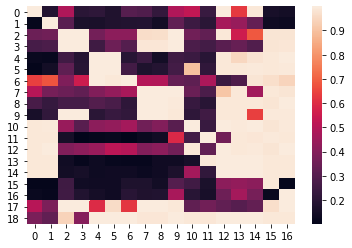

In [125]:
sns.heatmap(learner.model.Mf)

<AxesSubplot:>

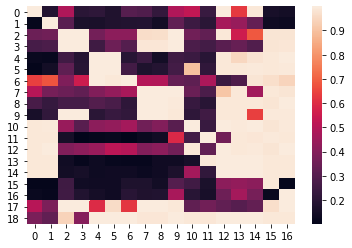

In [126]:
sns.heatmap(learner.model.Mf)

In [127]:
# most features are bad
(oy_pred - oy).pow(2).mean(0)

tensor([2.2234e-06, 6.6201e-06, 1.5721e-05, 3.5120e-04, 1.3711e-05, 4.2788e-06,
        1.1695e-03, 3.1752e-03, 1.7186e-03, 3.8602e-06, 2.1817e-03, 3.9165e-06,
        2.1894e-03, 2.5233e-06, 2.4981e-06, 2.7410e-06, 3.1893e-06],
       device='cuda:0', grad_fn=<MeanBackward1>)

In [131]:
opt = torch.optim.Adam(params=learner.model.parameters(), lr=1e-3)

In [132]:
# random init
ms = learner.non_sparse_model.all_models
for m in ms:
    getattr(learner.model, m).model.__init__(input_shape=(learner.model.n_features + learner.model.n_actions,),
                                            output_shape=(1,))
    getattr(learner.model, m).model.to(learner.device)
# list(getattr(learner.model, ms[0]).model.fc01.parameters())

In [63]:
assert learner.non_sparse_model.all_models == learner.model.all_models
for key in learner.non_sparse_model.all_models:
    m_nsp_i = getattr(learner.non_sparse_model, key)
    m_i = getattr(learner.model, key).model
    m_i.load_state_dict(m_nsp_i.state_dict())

In [133]:
losses = []

In [134]:
for _ in tqdm(range(50000)):
    opt.zero_grad()
    oy_pred = learner.model(f_t=ox, a_t=ax)
    loss = (oy_pred - oy).pow(2).mean()
    loss.backward()
    opt.step()
    losses.append(loss.item())

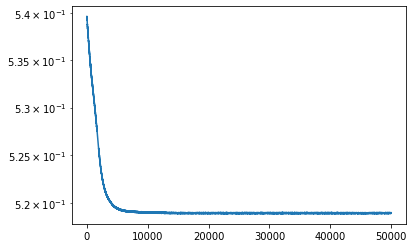

In [135]:
plt.plot(losses)
plt.yscale('log')

In [42]:
[x[1].min() for x in learner.model.switch__params]

[tensor(-1.2755, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(-1.4889, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(-0.2743, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(-0.9741, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(-1.3749, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(-1.3093, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(-1.1883, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(-0.5154, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(-1.0652, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(-0.9467, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(-0.8049, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(-0.5753, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(-0.7057, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(-1.6000, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(-1.4270, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(-1.3868, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(-1.4159, device='cuda:0', grad_fn=<MinBackward1>

In [130]:
for p in learner.model.switch__params:
    p_orig = p.data.detach().clone()
    print(p_orig)
#     break
    p.data[1, p_orig[1] < 0] = 0
    p.data[0, p_orig[1] < 0] = 0

tensor([[-2.9331,  0.7407,  0.0192,  0.6883,  0.6617,  0.7730,  0.4204,  0.4527,
          0.6278,  0.0156, -0.0523,  0.5838, -3.5201, -0.2642, -2.4068,  0.8288,
          0.8698,  0.6343,  0.5279,  0.4274,  0.6308],
        [ 2.9331, -0.7407, -0.0192, -0.6883, -0.6617, -0.7730, -0.4204, -0.4527,
         -0.6278, -0.0156,  0.0523, -0.5838,  3.5201,  0.2642,  2.4068, -0.8288,
         -0.8698, -0.6343, -0.5279, -0.4274, -0.6308]], device='cuda:0')
tensor([[ 1.0210, -3.0239,  0.4011,  0.8060,  0.8138,  0.7643,  0.7570,  0.7494,
          0.8916,  0.3619,  0.5634,  0.6872,  0.0596,  0.1230,  0.3410,  0.9181,
          0.9524,  0.7096,  0.6343,  0.7030,  0.6544],
        [-1.0210,  3.0239, -0.4011, -0.8060, -0.8138, -0.7643, -0.7570, -0.7494,
         -0.8916, -0.3619, -0.5634, -0.6872, -0.0596, -0.1230, -0.3410, -0.9181,
         -0.9524, -0.7096, -0.6343, -0.7030, -0.6544]], device='cuda:0')
tensor([[ 0.3154,  0.2894, -3.9236, -2.8235,  0.2770,  0.1616,  0.1619, -1.6962,
         -1.766

In [111]:
for key, param in learner.model.named_parameters():
    if 'switch' not in key:
        print(key)
        if 'bias' in key:
            torch.nn.init.zeros_(param)
        else:
            torch.nn.init.xavier_uniform_(param)

model_fout_0000.model.fc01.weight
model_fout_0000.model.fc01.bias
model_fout_0000.model.fc02.weight
model_fout_0000.model.fc02.bias
model_fout_0000.model.fc03.weight
model_fout_0000.model.fc03.bias
model_fout_0000.model.fc04.weight
model_fout_0000.model.fc04.bias
model_fout_0001.model.fc01.weight
model_fout_0001.model.fc01.bias
model_fout_0001.model.fc02.weight
model_fout_0001.model.fc02.bias
model_fout_0001.model.fc03.weight
model_fout_0001.model.fc03.bias
model_fout_0001.model.fc04.weight
model_fout_0001.model.fc04.bias
model_fout_0002.model.fc01.weight
model_fout_0002.model.fc01.bias
model_fout_0002.model.fc02.weight
model_fout_0002.model.fc02.bias
model_fout_0002.model.fc03.weight
model_fout_0002.model.fc03.bias
model_fout_0002.model.fc04.weight
model_fout_0002.model.fc04.bias
model_fout_0003.model.fc01.weight
model_fout_0003.model.fc01.bias
model_fout_0003.model.fc02.weight
model_fout_0003.model.fc02.bias
model_fout_0003.model.fc03.weight
model_fout_0003.model.fc03.bias
model_fout